# Hands-on Machine Learning - Chapter 7 - Ensemble Learning

# Setup

In [13]:
# Python 3.5 or above required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 0.20 or above required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports 
import numpy as np 
import os 

# Make notebook's outputs consistent across runs
np.random.seed(42)

# For plotting
import matplotlib.pyplot as plt 
import matplotlib as mpl 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Directories for saving figures
ROOT_DIR = '.'
IMAGES_PATH = os.path.join(ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers

## Law of Large Numbers Plot 

This plot explains why ensemble learning tends to give better results than using standalone models. We assume we have a biased coin that is heads 51% of the time and tails 49% of the time, so on average we expect it to be heads more frequently than tails. 

This will not always be the case. But if we toss the coin `n` times and as `n` $\rightarrow \infty$, we will find that the actual percentage of heads in the coin tosses will approach the probability of heads on a given coin toss. In this case, that probability is 51%, so the probability of getting a majority of heads (51) vs tails (49) becomes larger and larger as the number of coin tosses increases. This is due to the law of large numbers. 

By analogy, ensemble learning tends to outperform standalone models because as the number of classifiers increases, the majority of their predictions tends to approach the 'true' value of the prediction for that distribution of features. 

This is only true if 
- the classifiers are perfectly independent (like the coin toss: one coin toss does not affect the outcome of another). 
- all classifiers make uncorrelated errors.

In practice, this is not the case: if the classifiers are trained on the same data, they will make correlated errors and will not be perfectly independent.

In [14]:
# The probability of getting a heads with a biased coin
heads_proba = 0.51 

# Simulate 10k coin tosses 10 times. Assume each coin toss returns a random number between [0, 1]
# If this number is < heads probability, assume we got a tails. Store as bool.
# Convert the resutling boolean array to ints for counting
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)

In [15]:
# Count number of heads across all experiments on the same toss - express as ratio of 10k tosses
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

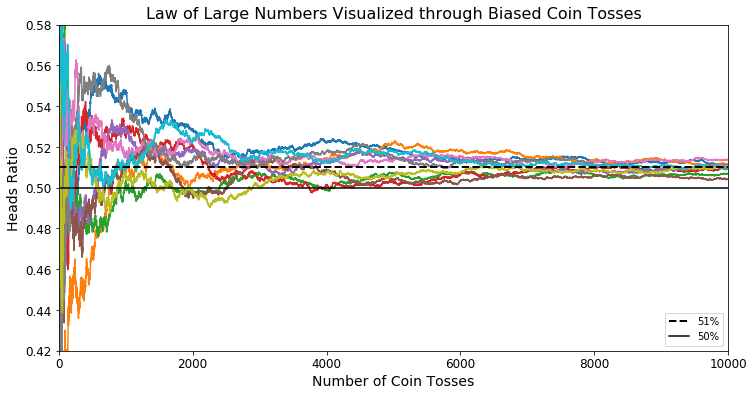

Saving figure law_of_large_numbers_plot


<Figure size 432x288 with 0 Axes>

In [18]:
# Plot the ratio of heads achieved on each coin toss across 10 experiments
plt.figure(figsize=(12, 6))
plt.plot(cumulative_heads_ratio)

# Straight line showing the 51% threshold - expected pct of heads over large number of tosses
plt.plot([0, 10000], [0.51, 0.51], 'k--', linewidth=2, label='51%')

# Straight line showing 50% threshold - if heads ratio above this, then heads in majority
plt.plot([0, 10000], [0.50, 0.50], 'k-', label='50%')

# Annotate axes
plt.xlabel('Number of Coin Tosses', fontsize=14)
plt.ylabel('Heads Ratio', fontsize=14)
plt.title('Law of Large Numbers Visualized through Biased Coin Tosses', fontsize=16)
plt.legend(loc='lower right')
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

# Save the figure
save_fig('law_of_large_numbers_plot')

## Hard Voting Classifier 

Using a `RandomForestClassifier`, a `SVC`, and a `LogisticRegression` classifier to predict the class of a sample from the `moons` dataset.  

In this ensemble classifier, the predicted class for a given sample will be the modal class predicted by the individual classifiers. Final predictions are not weighted according to the confidence score or predicted probability for each sample i.e. samples that are predicted to be positive with 51% likelihood are treated the same as samples predicted to be positive with 99% likelihood as far as the final prediction is concerned.

In [25]:
# Imports - dataset and processing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# Imports - classifiers 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Imports - classification accuracy and performance 
from sklearn.metrics import accuracy_score

### Making Dataset

In [20]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Building Models

In [21]:
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)

In [23]:
# Voting classifier instantiated using list of constituent classifiers
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
                              voting='hard')

### Training

In [24]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

### Evaluation

Compare accuracy (proportion of samples classified correctly) of individual classifiers and ensemble classifier. Ensemble classifier outperforms individual classifiers because the diversity of individual classifiers make different kinds of errors. These errors are much easier to identify when made by 1 of 3 classifiers, therefore ensuring they do not affect the final prediction.

In [26]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    # Fit the classifier to the same data
    clf.fit(X_train, y_train)
    
    # Make predictions on test data
    y_pred = clf.predict(X_test)
    
    # Print the accuracy score
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


## Soft Voting Classifier 

Same as previous voting classifier except that the predicted class isn't just based on the majority vote, but the class with the highest class probability (averaged over all individual classifiers), giving more weightage to highly confident votes. 

For instance, if the three classifiers predict (0, 1, 1) with confidence scores of (97%, 22%, 32%) for a given example, the final predicted class will be 0 because even though its not the majority prediction, its confidence score is much higher. 

In [27]:
# Instantiate classifiers
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Must specify `probability=True` here because SVC does not predict class probabilities by default
# And class probabilities are required for a soft voting classifier 
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

In [29]:
# Create a soft voting classifier 
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svm', svm_clf)], 
    voting='soft'
)

In [30]:
# Fit the classifier 
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [32]:
# Compare accuracies of individual classifiers with ensemble classifier
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    # Train
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Print accuracy
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging
- Aka Bootstrap aggregating.
- The process of training the same machine learning algorithm or model on different subsets of the training set.
- These subsets of the training set are **resampled with replacement**.
- This means that a single sample may be seen multiple times by the same model or predictor.
- Individual predictors are trained on smaller training data, and so have higher bias than an individual predictor trained on the entire training set.
- But bagging reduces overall bias and variance, which means overall bias of ensemble bagging predictor is the same as that of an individual predictor, but variance is lower.

## Example 1 - Bagging Classifier with `moons` Dataset

In [33]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier 

In [34]:
# Instantiate a bagging classifier - will make 500 different decision trees, each of which will
# be trained using 100 of the 500 available samples. Bagging means a single decision tree may 
# see the same training example several times during training. 
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500, max_samples=100, random_state=42)

In [35]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=None, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [36]:
print(accuracy_score(y_test, bag_clf.predict(X_test)))

0.904


In [37]:
# For comparison, consider an individual decision tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


### Decision Boundary Comparion - DecisionTree vs Bootstrap Decision Tree

In [38]:
from matplotlib.colors import ListedColormap

In [41]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], 
                          alpha=0.5, contour=True):
    # 100 linearly spaced values for horizontal axis
    x1s = np.linspace(axes[0], axes[1], 100)
    
    # 300 linearly spaced values for vertical axis
    x2s = np.linspace(axes[2], axes[3], 100)
    
    # Grid of coordinates defined by the horizontal and vertical axes values
    x1, x2 = np.meshgrid(x1s, x2s)
    
    # Reshape into column-wise features for use with prediction
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    # Predict a class for each distinct coordinate in the grid
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    # Define custom colors for positive class, negative class, and decision boundary
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    
    # Contour map - regions with the same class will have the same color
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    # If plotting individual contours, color map will change
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
        
    # Extract feature pairs of positive and negative classes, then plot as yellow circles or blue squares
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo', alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bs', alpha=alpha)
    
    # Redefine axes limits according to argument
    plt.axis(axes)
    
    # Annotate axes
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18, rotation=0)

Saving figure decision_tree_bagging_demo


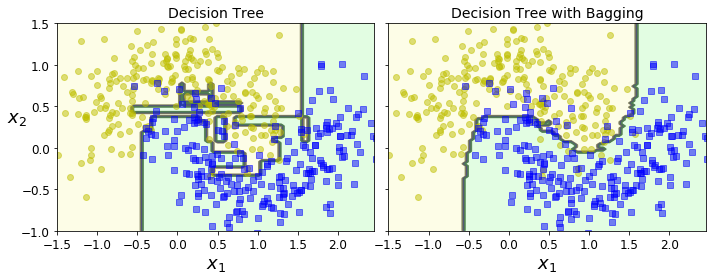

In [42]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# Left axes - Decision Tree
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title('Decision Tree', fontsize=14)

# Right axes - Bootstrap Decision Tree
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title('Decision Tree with Bagging', fontsize=14)
plt.ylabel('')

# Save the figure
save_fig('decision_tree_bagging_demo')

plt.show()

## Out of Bag Evaluation

1. With bagging/bootstrap aggregating, a single predictor draws `m` samples from a subset of the training set with replacement. 
2. This means it is possible for the predictor to see some samples more than once, and not to see some samples at all.
3. On average, a bagging predictor sees 63% of training set samples, which means remaing 37% of samples are 'out of the bag' used for training.
4. Out of bag samples can thus be used for evaluation as validation or test set samples. 

In [43]:
# Instantiate a bagging classifier, but also request an avg out of bag validation score for all predictors
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)

In [44]:
# Fit to the same moons training set
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=None, oob_score=True,
         random_state=40, verbose=0, warm_start=False)

In [45]:
# Average of all validation set scores
bag_clf.oob_score_

0.9013333333333333

In [46]:
# Evaluate on the test set 
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.912


The bagging classifier actually performs better on the test set than its average performance on out of bag validation samples. 

In [48]:
# Decision function returns the prediction output for each sample in the training set
bag_clf.oob_decision_function_[:10]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637]])

The `decision_function_` shows that the model predicts a 31.7% probability for the first training example to belong to the negative class (class `0`) and a 68.25% probability for it to belong to the positive class (class `1`).

# Random Forest Classifier 
- A random forest classifier is more or less a `BaggingClassifier` built using several instances of `DecisionTreeClassifier` with bagging (resampling with replacement) or pasting (resampling without replacement).
- Reduces additional randomness by sampling features among a subset of features in order to find a feature for the optimal split (split that minimizes `gini` impurity in the children nodes). 
    - Leads to slightly higher bias but lower variance.

## Random Forest: A Bagging Classifier of Decision Trees

The following cells demonstrate that a `RandomForestClassifier` is virtually the same as a `BaggingClassifier` of several `DecisionTreeClassifier` models. 

Both are trained on the same training data, and their predictions on the test data are then compared for similarity.

In [49]:
# Instantiate a bagging classifier of 500 decision trees with specific hyperparameters
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16, random_state=42), 
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [50]:
# Train and store predictions on text set
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [51]:
# Instnatiate a random forest classifier using the same hyperparameters as for the decision tree
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)

# Fit to the same training data
rnd_clf.fit(X_train, y_train)

# Make predictions on the same test set
y_pred_rf = rnd_clf.predict(X_test)

In [52]:
# Find proportion of samples for which bagging classifier of dtrees produces same results as random forest
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.96

## Extra Trees

- Extremely randomized trees.
- A form of a `RandomForestClassifier` in which feature thresholds for splitting are assumed to be random values and are not derived by searching for the feature value that leads to minimal impurity/entropy after the split. 
- Introduces yet another level of randomness in the random forest classifier, thereby increasing bias and decreasing variance.
- Also makes training faster, since optimal feature thresholds do not have to be computed. 

## Feature Importance in Random Forests
- Each random forest classifier consists of a number of Decision Tree classifiers.
- Each decision tree classifier uses a feature based on which the samples are split into two subsets according to a threshold value.
- Some features are used more frequently than others, suggesting that they are more strongly correlated with decreasing impurity. 
- Some features may not occur as frequently as others, but their resulting splits may cause a larger decrease in impurity. 
- Random Forest classifiers in `sklearn` maintain a record of which features result in the largest impurity reduction across all trees in the forst.
- This reduction is recorded as a weighted average - nodes with more training samples will have a larger weight. 

### Example 1 - Iris Dataset

In [62]:
from sklearn.datasets import load_iris

In [63]:
iris = load_iris()

In [64]:
# Extract features and labels
X = iris['data']
y = iris['target']

In [65]:
# Instantiate a random forest of 500 decision trees
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)

In [70]:
# Fit to the entire training data - all features, not just petal width and length
rnd_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [71]:
# Find feature importance scores (weighted averages acros all decision trees) for all models
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


### Example 2 - `MNIST` Dataset

In [74]:
from sklearn.datasets import fetch_openml

In [95]:
mnist = fetch_openml('mnist_784')

In [96]:
# Instantiate a random forest classifier
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Using the random forest's `feature_importances_` property to plot heatmap of which pixel value were important in classification.

Each image has 784 pixels (28 x 28 width and height). These 784 pixels intensities were the features used for training the random forest. The `RandomForestClassifier` trained 100 `DecisionTreeClassifier`s with bagging using different subsets of these 784 pixel intensities. Within each subset, not only did the `DecisionTreeClassifier` see some pixels/features more than once, but also chose a random subset of features/pixels to find the splitting threshold for. 

The heatmap shows which pixels, when used a feature for splitting nodes in Decision Trees, were found to cause the greatest decrease in `gini` impurity across all decision trees.

In [97]:
def plot_digit(data):
    """Plots a heatmap of feature importances for a particular image"""
    # Data is a 784-dimensional vector of relative feature importances of each pixel of a 28 by 28 px image
    # as computed by a RandomForestClassifier - higher pixel intensities correspond to pixels which were 
    # associated with a larger decrease in gini impurity during classification across all trees
    # Reshape these feature importances to 28 by 28 px image
    image = data.reshape(28, 28)
    
    # Overlay a heatmap on the image
    plt.imshow(image, cmap=mpl.cm.hot, interpolation='nearest')
    
    # Don't show pixel numbers on the axes
    plt.axis('off')

Saving figure mnist_feature_importance_plot


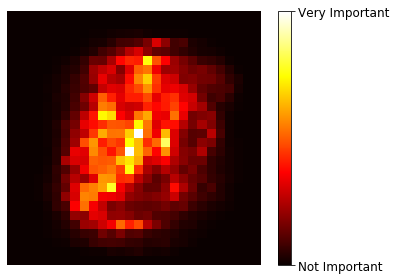

In [99]:
# Plot the feature importances - these apply to ALL images
plot_digit(rnd_clf.feature_importances_)

# Defining a colorbar with range in terms of minimum and maximum feature importances
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), 
                          rnd_clf.feature_importances_.max()])

# Annotate the color bar 
cbar.ax.set_yticklabels(['Not Important', 'Very Important'])

# Save the figure
save_fig('mnist_feature_importance_plot')

plt.show()

# Boosting 

- Any ensemble method that combines several weak learners into a strong learner is said to use **boosting**.
- A 'weak' learner is one that does not do much learning i.e. it performs only slightly better than a completely random predictor. 
- In boosting, we train several predictors. Each predictor tries to correct the mistakes made by its predecessor.